In [104]:
import csv
from collections import defaultdict, Counter
import pandas
import re
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'

In [105]:
from collections import namedtuple
import csv
import pathlib
import re
GTFRecord = namedtuple('GTFRecord',('seqname','source','feature','start','end','score','strand','frame','attr'))
class GTFParser(object) :
    attr_split_re = re.compile('([a-zA-Z_]+) "([^"]+)";')
    def __init__(self,f) :
        self._path_in = False
        if isinstance(f, str) or isinstance(f, pathlib.Path):
            self._path_in = True
            self._f = open(f)
        else :
            self._f = f
    def parse_attrs(attr) :
        attr_d = {}
        for at in GTFParser.attr_split_re.findall(attr) :
            k, v = at
            if len(at) == 0 : continue
            attr_d[k] = v.lstrip('\'"').strip('\'"')
        return attr_d
    def records(self) :
        for r in csv.reader(self._f,delimiter='\t') :
            # replace any . with None
            r = [_ if _ != '.' else None for _ in r]
            r[-1] = GTFParser.parse_attrs(r[-1])
            yield GTFRecord(*r)
    def __enter__(self):
        return self.records()
    def __exit__(self, type, value, traceback):
        if self._path_in :
            self._f.close()

In [106]:
taxclass_patt = re.compile('taxclass "([^"]*)"')
gene_stats = []
transcript_stats = []
gene_site = defaultdict(set)

with GTFParser('Holobiont_transcripts_hits.gtf') as f :
    for r in f :
        taxclass = r.attr.get('taxclass')
        if taxclass is None :
            taxclass = 'nohit'
        tid = r.attr.get('transcript_id')
        taxids = r.attr.get('staxids')
        if taxids is None :
            taxids = r.attr.get('taxa_ids')
        site = None
        if r.source == '.' : # no hit
            site = r.seqname[5:7]
        elif tid is not None :
            site = tid[5:7]
        d = {
                'gid': r.seqname,
                'site': site,
                'source': r.source,
                'taxclass': taxclass,
                'taxids': taxids
            }
        if r.feature == 'gene' :
            gene_stats.append(d)
        if r.feature == 'transcript' :
            transcript_stats.append(d)
            gene_site[d['gid']].add(d['site'])

gene_stats = pandas.DataFrame(gene_stats)
gene_stats.index = gene_stats.gid
transcript_stats = pandas.DataFrame(transcript_stats)

In [107]:
archive_fns = []

In [108]:
# set the site variable in gene_stats based on transcript stats
gene_stats['site'] = gene_stats.gid.apply(lambda x: list(gene_site[x])[0] if len(gene_site.get(x)) != 2 else 'Both')

In [109]:
taxmap = {
    'nohit': 'No hit',
    'cni': 'Cnidaria',
    'bacteria': 'Bacteria',
    'smb': 'Symbiodiniaceae',
    'meta_other': 'Other Metazoa',
    'euk_other': 'Other Eukaryota',
    'org_other': 'Other Organism',
    'fungi': 'Fungi',
    'other_seqs': 'Other Sequences',
    'virus': 'Virus',
    'archaea': 'Archaea'
}
gene_stats['Taxonomic Class'] = gene_stats.taxclass.map(taxmap)
transcript_stats['Taxonomic Class'] = transcript_stats.taxclass.map(taxmap)

In [110]:
gene_stats.groupby('site')['Taxonomic Class'].value_counts().to_csv('gene_stats_by_site.csv',header=True)

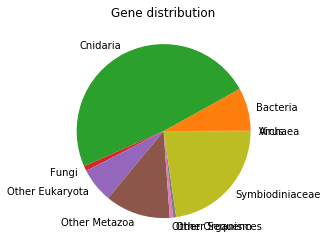

In [111]:
gene_stats.groupby('Taxonomic Class').count().drop(index='No hit').rename(columns={'gid':''})[''].plot.pie(title='Gene distribution')

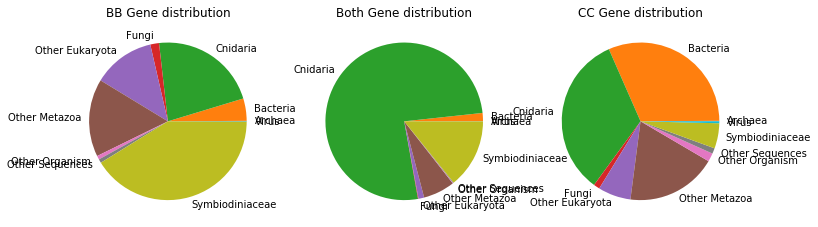

In [112]:
f, axs = plt.subplots(1,3,figsize=(12,4))
f.patch.set_facecolor('white')
for ax, (site, stats) in zip(axs, gene_stats.groupby('site')) :
    stats.groupby('Taxonomic Class').count().drop(index='No hit').rename(columns={'gid':''})[''].plot.pie(title='{} Gene distribution'.format(site),ax=ax)
f.savefig('gene_site_distribution_pie.svg')
archive_fns.append('gene_site_distribution_pie.svg')

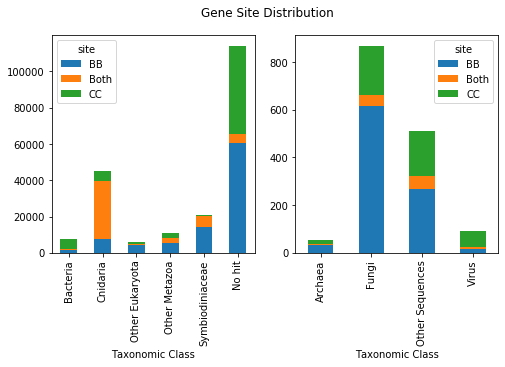

In [113]:
gene_stats_grouped = gene_stats.groupby(['site','Taxonomic Class'])['Taxonomic Class'].count().unstack('site')
gene_stats_grouped.to_csv('gene_site_distribution.csv')
archive_fns.append('gene_site_distribution.csv')

f, axs = plt.subplots(1,2,figsize=(8,4))
f.patch.set_facecolor('white')
gene_stats_grouped.loc[['Bacteria','Cnidaria','Other Eukaryota','Other Metazoa','Symbiodiniaceae','No hit']].plot(kind='bar', stacked=True,ax=axs[0])
gene_stats_grouped.loc[['Archaea','Fungi','Other Sequences','Virus']].plot(kind='bar', stacked=True,ax=axs[1])
f.suptitle('Gene Site Distribution')
f.savefig('gene_site_distribution_bar.svg')
archive_fns.append('gene_site_distribution_bar.svg')

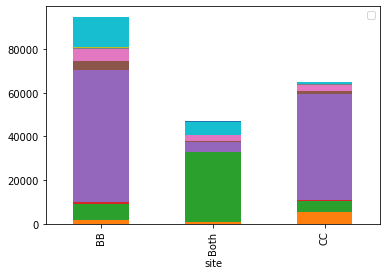

In [114]:
f = gene_stats.groupby(['site','Taxonomic Class'])['site'].count().unstack('Taxonomic Class').plot(kind='bar', stacked=True)
#f.axes.set_yscale('log')
f.legend('')

In [115]:
transcript_stats.groupby('site').taxclass.value_counts().to_csv('transcript_stats_by_site.csv',header=True)

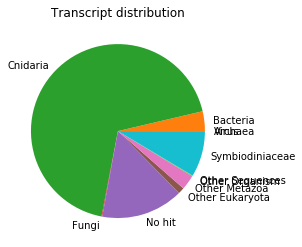

In [116]:
transcript_stats.groupby('Taxonomic Class').count().rename(columns={'gid':''})[''].plot.pie(title='Transcript distribution')

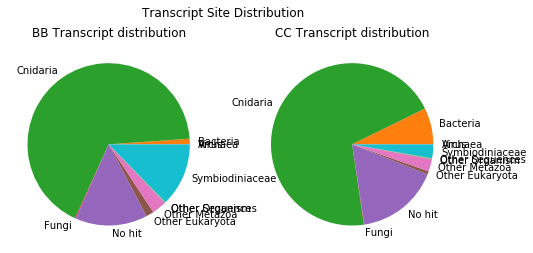

In [117]:
f, axs = plt.subplots(1,2,figsize=(8,4))
f.patch.set_facecolor('white')
for ax, (site, stats) in zip(axs,transcript_stats.groupby('site')) :
    stats.groupby('Taxonomic Class').count().rename(columns={'gid':''})[''].plot.pie(title='{} Transcript distribution'.format(site),ax=ax)
f.suptitle('Transcript Site Distribution')
f.savefig('transcript_site_distribution_pie.svg')
archive_fns.append('transcript_site_distribution_pie.svg')

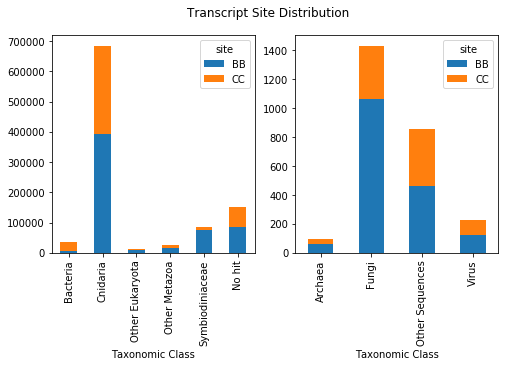

In [118]:
transcript_stats_grouped = transcript_stats.groupby(['site','Taxonomic Class'])['Taxonomic Class'].count().unstack('site')

f, axs = plt.subplots(1,2,figsize=(8,4))
f.patch.set_facecolor('white')
transcript_stats_grouped.loc[['Bacteria','Cnidaria','Other Eukaryota','Other Metazoa','Symbiodiniaceae','No hit']].plot(kind='bar', stacked=True,ax=axs[0])
transcript_stats_grouped.loc[['Archaea','Fungi','Other Sequences','Virus']].plot(kind='bar', stacked=True,ax=axs[1])
f.suptitle('Transcript Site Distribution')
f.savefig('transcript_site_distribution_bar.svg')
archive_fns.append('transcript_site_distribution_bar.svg')

tout = transcript_stats_grouped.copy()
tout['BB %'] = 100*tout['BB']/tout['BB'].sum()
tout['CC %'] = 100*tout['CC']/tout['CC'].sum()
tout.to_csv('transcript_site_distribution.csv')
archive_fns.append('transcript_site_distribution.csv')

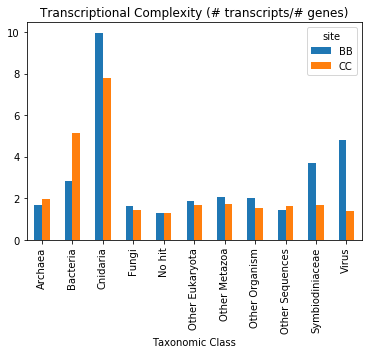

In [119]:
site_gene_stats_grouped = gene_stats_grouped.copy()
site_gene_stats_grouped['BB'] += gene_stats_grouped['Both']
site_gene_stats_grouped['CC'] += gene_stats_grouped['Both']
site_gene_stats_grouped.drop(columns='Both',inplace=True)

(transcript_stats_grouped/site_gene_stats_grouped).to_csv('transcriptome_complexity.csv')
archive_fns.append('transcriptome_complexity.csv')

f = (transcript_stats_grouped/site_gene_stats_grouped).plot(kind='bar',title='Transcriptional Complexity (# transcripts/# genes)')
f.patch.set_facecolor('white')
f.figure.savefig('transcriptome_complexity.svg')
archive_fns.append('transcriptome_complexity.svg')

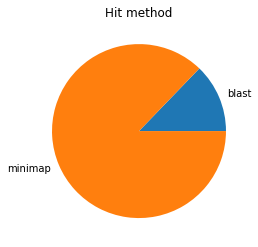

In [120]:
transcript_stats.groupby('source').count().to_csv('transcript_hit_method.csv')
archive_fns.append('transcript_hit_method.csv')

f = transcript_stats.groupby('source').count().rename(columns={'gid':''})[''].plot.pie(title='Hit method')
f.patch.set_facecolor('white')
f.figure.savefig('transcript_hit_method.svg')
archive_fns.append('transcript_hit_method.svg')

In [121]:
from zipfile import ZipFile
with ZipFile('transcript_stats.zip','w') as zipf :
    for fn in archive_fns :
        zipf.write(fn)
archive_fns

['gene_site_distribution_pie.svg',
 'gene_site_distribution.csv',
 'gene_site_distribution_bar.svg',
 'transcript_site_distribution_pie.svg',
 'transcript_site_distribution_bar.svg',
 'transcript_site_distribution.csv',
 'transcriptome_complexity.csv',
 'transcriptome_complexity.svg',
 'transcript_hit_method.csv',
 'transcript_hit_method.svg']

# CPM

In [122]:
counts = pandas.read_csv('all_salmon_quant.csv',index_col=0)
bb = ['B2','B11','B12','B22']
cc = ['F12','F18','F22','F23']
counts = counts[bb+cc]

# filter out genes that have more than one zero count per site
counts = counts.loc[((counts[bb]!=0).sum(axis=1)>=3) | ((counts[cc]!=0).sum(axis=1)>=3)]

# filter out genes that have all zeros in either site
#counts = counts.loc[
#    ((counts[bb]!=0).any(axis=1)) |
#    ((counts[cc]!=0).any(axis=1))
#]

# get rid of transcripts that don't map to a hit
counts = counts.loc[[_ for _ in counts.index if not _.startswith('Acer')]]
cpm = counts/counts.sum(axis=0)*10e6
cpm.shape

(71682, 8)

In [123]:
gene_stats.loc[cpm.head().index]
taxid_gene_map = defaultdict(list)
for gid, r in gene_stats.iterrows() :
    if r.taxids is None : continue
    for t in r.taxids.split(';') :
        taxid_gene_map[t].append(gid)

# Examine phylogenetic breakout of each taxclass by site

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
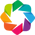

In [124]:
import json
import networkx as nx
from functools import reduce
from itertools import chain
import pydot
from networkx.drawing.nx_pydot import graphviz_layout
import holoviews as hv
from holoviews import dim, opts
from IPython.display import display

hv.notebook_extension('matplotlib')
hv.extension('bokeh')

In [125]:
help(opts.Graph)

Help on method builder in module holoviews.util:

builder(*, active_tools, align, apply_extents, apply_ranges, arrowhead_length, aspect, axiswise, backend, bgcolor, border, cformatter, clabel, clim, clipping_colors, cmap, color_levels, colorbar, colorbar_opts, colorbar_position, data_aspect, default_span, default_tools, directed, edge_alpha, edge_cmap, edge_color, edge_color_index, edge_fill_alpha, edge_fill_color, edge_hover_alpha, edge_hover_color, edge_hover_fill_alpha, edge_hover_fill_color, edge_hover_line_alpha, edge_hover_line_color, edge_line_alpha, edge_line_cap, edge_line_color, edge_line_dash, edge_line_join, edge_line_width, edge_muted, edge_muted_alpha, edge_muted_color, edge_muted_fill_alpha, edge_muted_fill_color, edge_muted_line_alpha, edge_muted_line_color, edge_nonselection_alpha, edge_nonselection_color, edge_nonselection_fill_alpha, edge_nonselection_fill_color, edge_nonselection_line_alpha, edge_nonselection_line_color, edge_selection_alpha, edge_selection_color, e

In [126]:
taxnames = {}
with open('hits/names.dmp') as f :
    for r in csv.reader(f,delimiter='|') :
        r = [_.strip() for _ in r]
        if r[3] == 'scientific name' :
            taxnames[r[0]] = r[1]

In [127]:
import networkx as nx
g = nx.DiGraph()
ranks = set()
with open('hits/nodes.dmp','rt') as f :
    for r in csv.reader(f,delimiter='|') :
        r = [_.strip() for _ in r]
        g.add_edge(r[1],r[0])
        g.nodes[r[1]]['n'] = taxnames[r[1]]
        g.nodes[r[0]]['n'] = taxnames[r[0]]
        g.nodes[r[0]]['rank'] = r[2]
        ranks.add(r[2])

In [128]:
taxonids = { 
    'cni': '6073',
    'smb': '252141',
    'meta': '33208',
    'euk': '2759',
    'archaea': '2157',
    'fungi': '4751',
    'bacteria': '2',
    'virus': '10239',
    'other_seqs': '28384'
}
with open('subtaxa.json') as f :
    subtaxa = json.load(f)
    for k in subtaxa :
        if k in taxonids :
            subtaxa[k].append(taxonids.get(k))

In [129]:
subgraphs = {}
def reduce_tree(g,nodes) :
    # first get rid of all leaf nodes not in nodes
    print('tree size: {}'.format(len(g)))
    for n in list(g.nodes) :
        if n not in nodes and g.out_degree(n) == 0 :
            g.remove_node(n)
            
    print('tree size after leaf prune: {}'.format(len(g)))
    # find root(s)
    roots = [_ for _ in g.nodes if g.in_degree(_) == 0]
    
    # now remove intermediate nodes that are not in nodes
    for root in roots :
        for n in list(nx.algorithms.dag.descendants(g,root)) :
            if n not in nodes :
                pred = list(g.predecessors(n))
                assert len(pred) == 1
                pred = pred[0]

                for succ in list(g.successors(n)) :
                    g.add_edge(pred,succ)
                    
                g.remove_node(n)
    print('tree size after subset: {}'.format(len(g)))
    
    return g
    

In [130]:
def prune_tree(g,nodes) :
    
    print('tree size: {}'.format(len(g)))
    
    # find the leaves that are not in nodes
    leaves = [_ for _ in g.nodes if g.out_degree(_) == 0 and _ not in nodes]
    
    print('num leaves: {}'.format(len(leaves)))
    
    # prune up leaves until we hit a node in nodes
    while len(leaves) > 0 :
        for leaf in leaves :
            g.remove_node(leaf)    
        leaves = [_ for _ in g.nodes if g.out_degree(_) == 0 and _ not in nodes]
    print('tree size after pruning: {}'.format(len(g)))
    
    return g


stats_d = defaultdict(dict)

taxgraphs = {}
for taxclass,nodes in subtaxa.items() :
    print(taxclass)
    #if taxclass != 'org_other' : continue
        
    subgraph = nx.DiGraph(g.subgraph(nodes))
    
    tax_stats = transcript_stats[transcript_stats.taxclass == taxclass]
    
    # filter based on cpm
    tax_stats = tax_stats[tax_stats.gid.isin(cpm.index)]
    
    # cc
    taxids = set(chain(*[_.split(';') for _ in tax_stats[tax_stats.site == 'CC'].taxids if _ is not None]))
    cc_taxids = taxids.difference(['NA',''])
    cc_taxgraph = prune_tree(subgraph.copy(),cc_taxids)
    #cc = hv.Graph.from_networkx(taxgraph, graphviz_layout, prog=layout).opts(tools=['hover'])
    
    # bb
    taxids = set(chain(*[_.split(';') for _ in tax_stats[tax_stats.site == 'BB'].taxids if _ is not None]))
    bb_taxids = taxids.difference(['NA',''])
    bb_taxgraph = prune_tree(subgraph.copy(),bb_taxids)
    #bb = hv.Graph.from_networkx(taxgraph, graphviz_layout, prog=layout).opts(tools=['hover'])
    #break
    
    taxgraph = cc_taxgraph.copy()
    taxgraph.add_nodes_from(bb_taxgraph.nodes)
    taxgraph.add_edges_from(bb_taxgraph.edges)

    # add attributes to the graph so we can draw them
    for n in taxgraph.nodes :
        in_cc = n in cc_taxids
        in_bb = n in bb_taxids
        
        site = 'None'
        if in_cc and in_bb :
            site = 'Both'
        elif in_cc :
            site = 'CC'
        elif in_bb :
            site = 'BB'

        taxgraph.nodes[n]['site'] = site
        taxgraph.nodes[n]['n'] = taxnames[n]
        
        # cpm by site
        # find all the genes for this taxid
        genes = taxid_gene_map[n]
        genes = set(genes).intersection(cpm.index)
        cc_cpm = cpm.loc[genes,cc].sum().sum()
        cc_detected = (cpm.loc[genes,cc]!=0).any(axis=1).sum()
                
        taxgraph.nodes[n]['CC_cpm'] = cc_cpm
        taxgraph.nodes[n]['CC_genes'] = cc_detected
        
        bb_cpm = cpm.loc[genes,bb].sum().sum()
        bb_detected = (cpm.loc[genes,bb]!=0).any(axis=1).sum()
        
        taxgraph.nodes[n]['BB_cpm'] = bb_cpm
        taxgraph.nodes[n]['BB_genes'] = bb_detected

        stats_d[n].update({
            'taxid': n,
            'taxclass': taxclass,
            'site':site,
            'CC_cpm': cc_cpm,
            'CC_genes': cc_detected,
            'BB_cpm': bb_cpm,
            'BB_genes': bb_detected,
            'direct_genes': (cc_detected+bb_detected)>0,
            'direct_trx': site!='None',
            'direct_cpm': (cc_cpm+bb_cpm)>0,
            'name': taxnames[n]
        })
        
    # compute 'purity' scores based on the difference between sites in:
    # - number of unique taxa per node
    # - cpm of counts mapping to node and all children
    # - number of unique genes mapping to node and all children
    for n in taxgraph.nodes :

        site_counts = Counter()
        site_cpm = Counter()
        site_genes = Counter()
        children = list(nx.algorithms.dag.descendants(taxgraph,n))+[n]
        for succ in children :
            site_counts[taxgraph.nodes[succ]['site']+'_taxa'] += 1
            
            site_cpm['CC_cpm'] += stats_d[succ]['CC_cpm']
            site_genes['CC_genes'] += stats_d[succ]['CC_genes']
            
            site_cpm['BB_cpm'] += stats_d[succ]['BB_cpm']
            site_genes['BB_genes'] += stats_d[succ]['BB_genes']
        
        # taxa purity
        count_diff = site_counts['BB_taxa']-site_counts['CC_taxa']
        max_count = site_counts['BB_taxa']+site_counts['CC_taxa']+site_counts['Both_taxa']
        taxa_purity = count_diff/max(max_count,1)
        assert 0 <= abs(taxa_purity) <= 1
        taxgraph.nodes[n]['taxa_purity'] = taxa_purity
        
        # cpm purity
        cpm_diff = site_cpm['BB_cpm']-site_cpm['CC_cpm']
        tot_cpm = site_cpm['BB_cpm']+site_cpm['CC_cpm']
        cpm_purity = cpm_diff/max(tot_cpm,1)
        assert 0 <= abs(cpm_purity) <= 1
        taxgraph.nodes[n]['cpm_purity'] = cpm_purity
        
        # detected gene purity
        gene_diff = site_genes['BB_genes']-site_genes['CC_genes']
        tot_genes = site_genes['BB_genes']+site_genes['CC_genes']
        gene_purity = gene_diff/max(tot_genes,1)
        assert 0 <= abs(gene_purity) <= 1
        taxgraph.nodes[n]['gene_purity'] = gene_purity
        
        stats_d[n].update({
            'taxa_diff': count_diff,
            'max_taxa': max_count,
            'taxa_purity': taxa_purity,
            'cpm_diff': cpm_diff,
            'tot_BB_cpm': site_cpm['BB_cpm'],
            'tot_CC_cpm': site_cpm['CC_cpm'],
            'tot_cpm': tot_cpm,
            'cpm_purity': cpm_purity,
            'gene_diff': gene_diff,
            'tot_BB_genes': site_genes['BB_genes'],
            'tot_CC_genes': site_genes['CC_genes'],
            'tot_genes': tot_genes,
            'gene_purity': gene_purity
        })
        stats_d[n].update(**site_counts)
        #stats_d[n].update(**site_cpm)
        #stats_d[n].update(**site_genes)
          
        for k,v in stats_d[n].items() :
            if k != 'name' :
                taxgraph.nodes[n][k] = v

    taxgraphs[taxclass] = taxgraph

cni
tree size: 11179
num leaves: 8972
tree size after pruning: 122
tree size: 11179
num leaves: 8964
tree size after pruning: 126
smb
tree size: 2725
num leaves: 2641
tree size after pruning: 38
tree size: 2725
num leaves: 2641
tree size after pruning: 41
archaea
tree size: 13496
num leaves: 12434
tree size after pruning: 19
tree size: 13496
num leaves: 12417
tree size after pruning: 84
fungi
tree size: 166745
num leaves: 152860
tree size after pruning: 371
tree size: 166745
num leaves: 152670
tree size after pruning: 1013
bacteria
tree size: 506949
num leaves: 488238
tree size after pruning: 1582
tree size: 506949
num leaves: 487998
tree size after pruning: 2300
virus
tree size: 205663
num leaves: 199354
tree size after pruning: 45
tree size: 205663
num leaves: 199354
tree size after pruning: 50
other_seqs
tree size: 15594
num leaves: 15537
tree size after pruning: 49
tree size: 15594
num leaves: 15559
tree size after pruning: 26
meta_other
tree size: 1033042
num leaves: 921365
tree s

In [131]:
defaults = dict(width=500, height=500)
hv.opts.defaults(
    opts.EdgePaths(**defaults),
    opts.Graph(**defaults),
    opts.Nodes(**defaults)
)

layout = 'dot'

site_cmap = {'None':'white','CC':'blue','BB':'red','Both':'black'}

# -1 Calabash Blue -> 1 Blackbird Red
levels = [-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]
colors = ['#0000ff','#3333ff','#9999ff','#ffffff','#ffffff','#ff9999','#ff3333','#ff0000']

# ensure -1 == blue and 1 == red always
cmap = plt.cm.get_cmap('coolwarm')

direct_map_color = {True: '#000000', False: '#555555'}
direct_map_width = {True: 2, False: 1}

for taxclass, taxgraph in taxgraphs.items() :
    
    if taxclass not in ('cni','smb','virus','archaea') : continue
    
    gr = hv.Graph.from_networkx(taxgraph, graphviz_layout, prog=layout)

    taxa_gr = gr.clone().opts(
        opts.Graph(
            node_size=10,
            node_color=dim('taxa_purity'),
            clim=(-1,1),
            node_line_color=dim('direct_trx').categorize(direct_map_color),
            node_line_width=dim('direct_trx').categorize(direct_map_width),
            edge_color='#555555',
            cmap='coolwarm',
            title='{} taxa purity'.format(taxclass),
            tools=['hover','click'],
            xaxis=None,
            yaxis=None
        )
        )
    
    gene_gr = gr.clone().opts(
        opts.Graph(
            node_size=10,
            node_color=dim('gene_purity'),
            clim=(-1,1),
            node_line_color=dim('direct_genes').categorize(direct_map_color),
            node_line_width=dim('direct_genes').categorize(direct_map_width),
            edge_color='#555555',
            cmap='coolwarm',
            title='{} gene purity'.format(taxclass),
            tools=['hover'],
            xaxis=None,
            yaxis=None
        )
    )

    cpm_gr = gr.clone().opts(
        opts.Graph(
            node_size=10,
            node_color=dim('cpm_purity'),
            clim=(-1,1),
            node_line_color=dim('direct_cpm').categorize(direct_map_color),
            node_line_width=dim('direct_cpm').categorize(direct_map_width),
            edge_color='#555555',
            cmap='coolwarm',
            title='{} cpm purity'.format(taxclass),
            tools=['hover'],
            xaxis=None,
            yaxis=None
        )
    )
    
    gr = taxa_gr + gene_gr + cpm_gr
    # need this to export to png
    renderer = hv.renderer('bokeh').instance(dpi=300)
    png, info = renderer(gr, fmt='png', dpi=300)
    with open('taxgraph_{}.png'.format(taxclass),'wb') as f:
        f.write(png)
    
    hv.save(gr, 'taxgraph_{}.html'.format(taxclass), fmt='html')
    display(gr)

:Layout
   .Graph.I   :Graph   [start,end]
   .Graph.II  :Graph   [start,end]
   .Graph.III :Graph   [start,end]

:Layout
   .Graph.I   :Graph   [start,end]
   .Graph.II  :Graph   [start,end]
   .Graph.III :Graph   [start,end]

:Layout
   .Graph.I   :Graph   [start,end]
   .Graph.II  :Graph   [start,end]
   .Graph.III :Graph   [start,end]

:Layout
   .Graph.I   :Graph   [start,end]
   .Graph.II  :Graph   [start,end]
   .Graph.III :Graph   [start,end]

In [132]:
from holoviews.plotting.util import process_cmap
help(hv.renderer('bokeh'))

Help on BokehRenderer in module holoviews.plotting.bokeh.renderer object:

class BokehRenderer(holoviews.plotting.renderer.Renderer)
 |  params(theme=ClassSelector, webgl=Boolean, backend=String, css=Dict, dpi=Integer, fig=ObjectSelector, fps=Number, holomap=ObjectSelector, mode=ObjectSelector, post_render_hooks=Dict, size=Integer, widget_location=ObjectSelector, widget_mode=ObjectSelector, info_fn=Callable, key_fn=Callable, name=String)
 |  Parameters of 'BokehRenderer'
 |  =============================
 |  
 |  Parameters changed from their default values are marked in red.
 |  Soft bound values are marked in cyan.
 |  C/V= Constant/Variable, RO/RW = ReadOnly/ReadWrite, AN=Allow None
 |  
 |  Name                                 Value                         Type       Bounds    Mode  
 |  
 |  backend                             'bokeh'                       String                V RW  
 |  css                                    {}                          Dict                 V RW 

In [133]:
# add full taxonomic lineage to each taxon
def get_rank(rank) :
    rank_order = (
        'superkingdom',
        'kingdom',
        'subkingdom',
        'superphylum',
        'phylum',
        'subphylum',
        'superclass',
        'class',
        'subclass',
        'infraclass',
        'cohort',
        'superorder',
        'order',
        'suborder',
        'infraorder',
        'parvorder',
        'superfamily',
        'family',
        'subfamily',
        'tribe',
        'subtribe',
        'genus',
        'subgenus',
        'section',
        'species group',
        'species subgroup',
        'species',
        'varietas',
        'forma',
        'subspecies',
        'serotype',
        'no rank'
    )
    if rank not in rank_order :
        raise Exception('Unrecognized rank: {}'.format(rank))

    return rank_order.index(rank)

def get_ranked_taxon(taxon,g,min_rank='species') :
    
    taxon = str(taxon)
    
    if taxon not in g :
        return 'NA','NA'
    
    node_rank = g.nodes[taxon]['rank']
    node_rank_i = get_rank(node_rank)
    min_rank_i = get_rank(min_rank)
    
    if node_rank_i <= min_rank_i :
        return taxon, node_rank
    else :
        # starting at node taxon, walk up the graph
        # until we find a taxon with rank at least min_rank
        while True :
            parents = list(g.predecessors(taxon))
            # there is a self edge from 1 for some reason
            if parents == ['1'] :
                return '1','tiptop'
            if len(parents) == 0 : # reached root
                return taxon, g.nodes[taxon]['rank']
            elif len(parents) > 1 :
                raise Exception('Multiple parents found for node {}, this shouldnt happen so I am aborting most cowardly'.format(taxon))
            parent = parents[0]
            node_rank = g.nodes[parent]['rank']
            node_rank_i = get_rank(node_rank)
            if node_rank_i <= min_rank_i :
                return parent, node_rank
            taxon = parent
            
default_ranks = (
    'superkingdom',
    'kingdom',
    'phylum',
    'class',
    'order',
    'family',
    'genus'
)
def get_taxon_lineage(taxon,g,ranks=default_ranks) :
    taxon = str(taxon)
    
    if taxon not in g :
        return {k:'NA' for K in default_ranks}
    
    node_rank = g.nodes[taxon]['rank']
    
    # get the path to the top
    path = []
    while True :
        parents = list(g.predecessors(taxon))
        assert len(parents) == 1
        # there is a self edge from 1 for some reason
        if parents == ['1'] :
            break
        else :
            path.append((g.nodes[taxon]['rank'],taxon))
            taxon = parents[0]
    path = dict(path)
    return {k:path.get(k,'NA') for k in default_ranks}

In [134]:
for k in stats_d.keys() :
    lineage_d = get_taxon_lineage(stats_d[k]['taxid'],g)
    lineage_d = {k:taxnames.get(v,'') for k,v in lineage_d.items()}
    stats_d[k].update(lineage_d)
    if k in g.nodes :
        stats_d[k]['rank'] = g.nodes[k]['rank']

In [136]:
fieldnames = (
    'taxid',
    'superkingdom',
    'kingdom',
    'phylum',
    'class',
    'order',
    'family',
    'genus',
    'name',
    'rank',
    'taxclass',
    'site',
    'taxa_diff',
    'max_taxa',
    'taxa_purity',
    'cpm_diff',
    'tot_cpm',
    'cpm_purity',
    'gene_diff',
    'tot_genes',
    'gene_purity',
    'CC_taxa',
    'BB_taxa',
    'Both_taxa',
    'None_taxa',
    'CC_cpm',
    'tot_CC_cpm',
    'tot_BB_cpm',
    'BB_cpm',
    'CC_genes',
    'tot_CC_genes',
    'BB_genes',
    'tot_BB_genes',
    'direct_trx',
    'direct_genes',
    'direct_cpm'
)
with open('taxgraph_stats.csv','wt') as f :
    f = csv.DictWriter(f,fieldnames=fieldnames)
    f.writeheader()
    f.writerows(stats_d.values())

In [137]:
stats_df = pandas.DataFrame(stats_d).T.fillna(0)

In [138]:
import hvplot.pandas
stats_df.hvplot(x='cpm_purity',y='gene_purity',by='taxclass',kind='scatter',alpha=0.8)

:NdOverlay   [taxclass]
   :Scatter   [cpm_purity]   (gene_purity)

In [139]:
stats_df.sort_values('cpm_purity',ascending=False)

taxid   taxclass  site    CC_cpm  CC_genes     BB_cpm  BB_genes  \
2653157  2653157   bacteria    BB  0.000000         0  16.253873         1   
1273155  1273155   bacteria  None  0.000000         0   0.000000         0   
178876    178876      fungi    BB  0.000000         0   2.543362         1   
2033802  2033802   bacteria    BB  0.000000         0  12.098771         1   
1157616  1157616      fungi    BB  0.000000         0   4.440722         1   
...          ...        ...   ...       ...       ...        ...       ...   
361085    361085  euk_other    CC  4.283213         1   0.000000         0   
1879049  1879049   bacteria    CC  8.293801         1   0.000000         0   
2644389  2644389   bacteria  None  0.000000         0   0.000000         0   
579          579   bacteria  None  0.000000         0   0.000000         0   
128122    128122        cni  None  0.000000         0   0.000000         0   

         direct_genes  direct_trx  direct_cpm  ... superkingdom  kingdom  \
2653157          True        True        True  ...     Bacteria            
1273155         False       False       False  ...     Bacteria            
178876           True        True        True  ...    Eukaryota    Fungi   
2033802          True        True        True  ...     Bacteria            
1157616          True        True        True  ...    Eukaryota    Fungi   
...               ...         ...         ...  ...          ...      ...   
361085           True        True        True  ...    Eukaryota            
1879049          True        True        True  ...     Bacteria            
2644389         False       False       False  ...     Bacteria            
579             False       False       False  ...     Bacteria            
128122          False       False       False  ...    Eukaryota  Metazoa   

                 phylum                class                order  \
2653157  Actinobacteria       Actinobacteria  Propionibacteriales   
1273155  Proteobacteria  Gammaproteobacteria         Chromatiales   
178876    Basidiomycota      Tremellomycetes          Tremellales   
2033802  Proteobacteria  Gammaproteobacteria    Oceanospirillales   
1157616      Ascomycota      Dothideomycetes          Capnodiales   
...                 ...                  ...                  ...   
361085           Evosea          Eumycetozoa                        
1879049  Proteobacteria  Gammaproteobacteria      Pseudomonadales   
2644389  Proteobacteria  Gammaproteobacteria     Enterobacterales   
579      Proteobacteria  Gammaproteobacteria     Enterobacterales   
128122         Cnidaria             Hydrozoa         Limnomedusae   

                     family           genus      rank  Both_taxa  BB_taxa  
2653157     Nocardioidaceae    Nocardioides   species          0        1  
1273155                      Thiohalobacter     genus          0        1  
178876      Cryptococcaceae    Cryptococcus  varietas          0        1  
2033802      Halomonadaceae       Halomonas   species          0        1  
1157616  Teratosphaeriaceae         Hortaea   no rank          0        1  
...                     ...             ...       ...        ...      ...  
361085                           Synstelium   species          0        0  
1879049       Moraxellaceae   Acinetobacter   species          0        0  
2644389  Enterobacteriaceae     Citrobacter   no rank          0        0  
579      Enterobacteriaceae        Kluyvera     genus          0        0  
128122                                          order          0        0  

[8376 rows x 36 columns]

In [140]:
stats_df.query('rank == "order" and taxclass == "bacteria"').hvplot(x='cpm_purity',y='taxa_purity',kind='scatter')

:Scatter   [cpm_purity]   (taxa_purity)

In [141]:
stats_df.query('rank == "order" and taxclass == "bacteria"').hvplot(x='cpm_purity',y='gene_purity',kind='scatter')

:Scatter   [cpm_purity]   (gene_purity)

In [142]:
stats_df.query('rank == "order" and taxclass == "bacteria"').hvplot(x='taxa_purity',y='gene_purity',kind='scatter')

:Scatter   [taxa_purity]   (gene_purity)

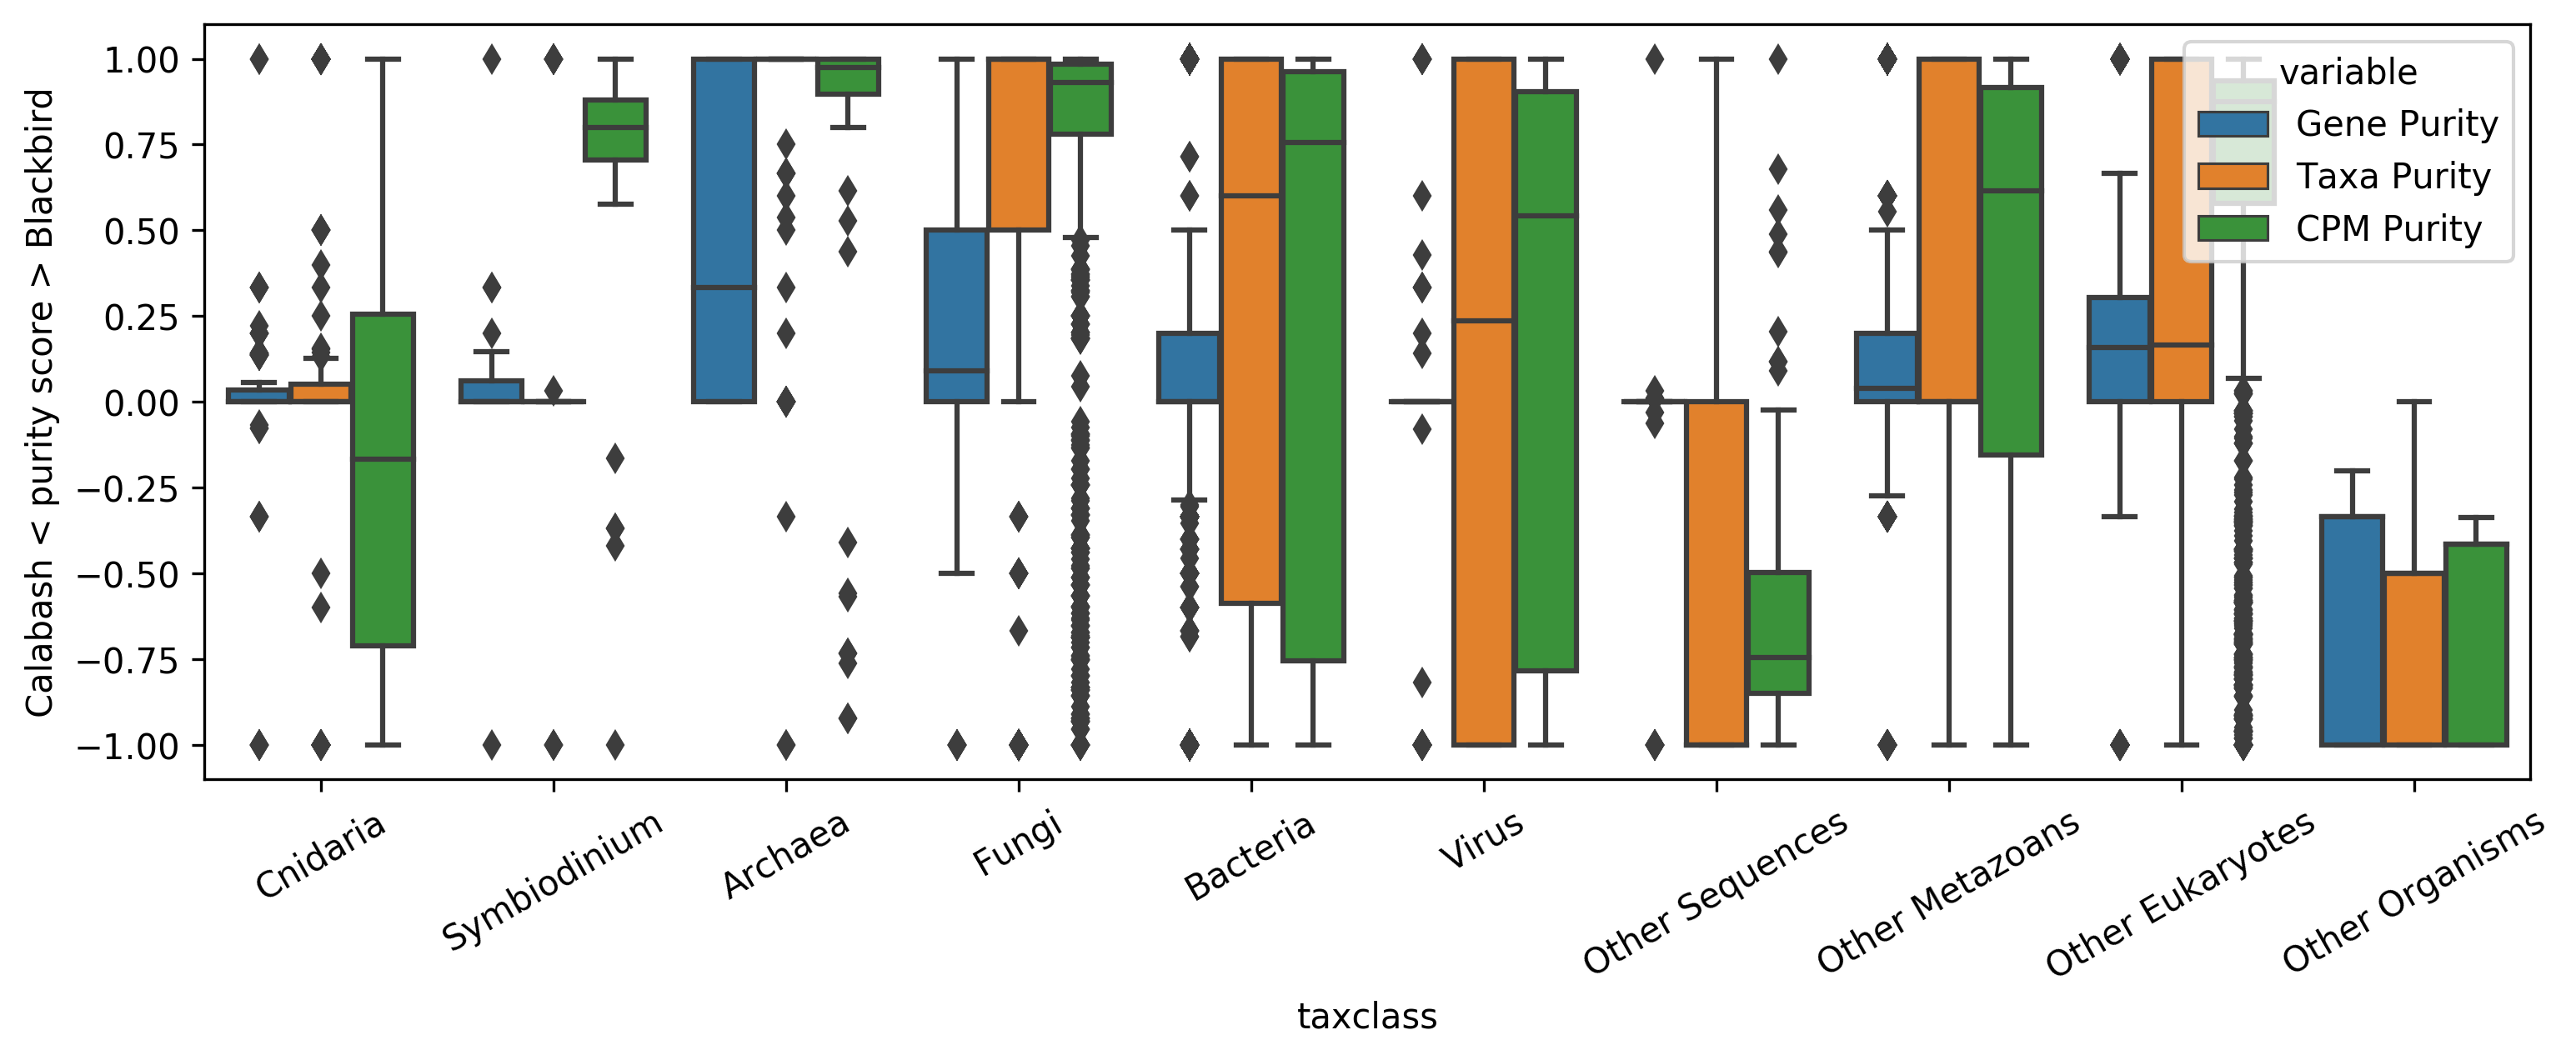

In [146]:
import seaborn as sns
plt.figure(figsize=(12,4),dpi=300)

f = sns.boxplot(
    x='taxclass',
    y='value',
    hue='variable',
    data=stats_df#.query('BB_genes != 0 or CC_genes != 0')
        [['taxclass','gene_purity','taxa_purity','cpm_purity']].rename(columns={
        'gene_purity': 'Gene Purity',
        'taxa_purity': 'Taxa Purity',
        'cpm_purity':'CPM Purity'
    }).melt(
        id_vars='taxclass',value_vars=['Gene Purity','Taxa Purity','CPM Purity']
    )
)
f.set_ylabel('Calabash < purity score > Blackbird')
f.xaxis.set_ticklabels([
    'Cnidaria','Symbiodinium','Archaea','Fungi','Bacteria','Virus',
    'Other Sequences','Other Metazoans','Other Eukaryotes','Other Organisms'
],rotation=30);

In [ ]:
stats_df.query('taxa_purity == -2')